## Star Data Prep
The stars displayed on the PANOTPES 3D app are from the Mag 5 Star Catalog by Dr. John P. Pratt (<a href="https://www.johnpratt.com/items/astronomy/mag_5_stars.html">johnpratt.com/items/astronomy/mag_5_stars.html</a>), which itself is a subset of the Yale Bright Star Catalog. The Mag 5 Star Catalog contains stars brighter than (or, less than) 5.5 visual magnitude*, totaling 3,923 stars.

Here, the columns relevant to render stars (converted RA+Dec\*\*, brightness, color, constellation) are exported into a JS array. The star brightness threshold may be increased as well, decreasing the number of stars displayed, in order to optimize app performance/FPS.

A small number of the stars are missing a B-V color, so for now, they will be replaced with 0.45 (roughly white on the B-V color index\*\*\*). Later on, these stars can be queried in SIMBAD and have this temporary value replaced with the proper one.

<small><small>\*Certain stars dimmer than this were kept in the catalog for meeting other criterea; see the webpage for more details
<br>
\*\*Each star's RA and Dec will be converted from spherical coordinates, and then Cartesian (x, y, z) for placement in the 3D scene.
<br>
\*\*\*See <a href="https://en.wikipedia.org/wiki/Color_index">en.wikipedia.org/wiki/Color_index</a></small></small>

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, pi
import numpy as np

In [24]:
# Set sky radius here, to match 3D scene
sky_radius = 18.4

In [38]:
# Import relevant columns from Mag 5 Star Catalog as dataframe

# Relevant columns are:
# [6] Constellation ID # (int)
# [8-10] RA HMS (int, int, float)
# [11] Dec hemisphere (string: 'N' or 'S')
# [12-14] Dec DMS (int)
# [15] Visual mag (float)
# [16] B-V color index (float)

cols = [6, 8, 9, 10, 11, 12, 13, 14, 15, 16]
col_names = ['con', 'ra_h', 'ra_m', 'ra_s', 'hem', 'dec_d', 'dec_m', 'dec_s', 'vmag', 'bv']

stars = pd.read_table('mag_5_stars.csv', delimiter=',', usecols=cols, header=0, names=col_names)

In [43]:
stars_arr[1000]

[1.0132, 16.8843, -7.2424, 4.33, -0.24, 34.0]

In [42]:
stars.iloc[1000]

con        34
ra_h        6
ra_m       31
ra_s     51.3
hem         S
dec_d      23
dec_m      25
dec_s       6
vmag     4.33
bv      -0.24
Name: 1000, dtype: object

In [189]:
# Create list for all the stars, each entry being a list of parameters of a particular star
stars_arr = []


# Need these to convert RA and Dec

def ra_hms_to_dd(h, m, s):
    dd = (15*h) + (15*m/60) + (15*s/3600)
    return dd

def dec_dms_to_dd(d, m, s):
    dd = d + (m/60) + (s/3600)
    
    return dd

def deg_to_rad(deg):
    return deg * pi / 180.

def equatorial_to_cartesian(sky_radius, ra_rad, dec_rad, hem):
    '''Takes the following:
    sky_radius: arbitrary radius of sky in 3D scene. 
                (Best if a few decimal points smaller than actual radius, to avoid z-fighting)
                (should I just take the actual val and handle that in here?? ...whatever)
    ra_rad: RA in radians
    dec_rad: Dec in radians (MUST BE POSITIVE)
    hem: used to specify whether y-coord is + or - (if star is in N or S hemisphere)
         (Note: The y-axis in three.js is the conventional "up"/z-axis. 
         Conventional y and x are the x and z axes, respectively, in three.js)
    
    Returns x, y, z coordinates rounded to 4 decimal places.
    '''
    
    # Here, rho = distance from point to origin,
    # theta = equator angle around the vertical axis,
    # phi = angle from vertical/up axis.
    # Sign of phi must be flipped because RA goes clockwise, and phi goes counterclockwise.
#     if hem == 'N':
#         const = 0
#     elif hem == 'S':
#         const = pi/2.
    
#     rho = sky_radius
#     theta = -1 * ((pi / 2) - dec_rad)
#     phi = sign * ra_rad
    rho = sky_radius
    theta = -1 * ra_rad
    phi = pi/2. - dec_rad
    
    if hem == 'N':
        sign = 1
    elif hem == 'S':
        sign = -1

    z = round(rho * sin(phi) * cos(theta), 4)
    y = sign * round(rho * cos(phi), 4)
    x = round(rho * sin(phi) * sin(theta), 4)
    
    return x, y, z

In [190]:
ra_hms_to_dd(24,4,0)

361.0

In [191]:
stars_arr_debug = []

In [192]:
# Iterate over all stars (rows in df) to extract each star's data
# Save this data in mag_5_stars.js
# Also log how many stars were missing B-V color data

count_missing_color = 0
for i in range(len(stars)):
    
    # Convert star RA HMS to decimal degrees; round to 4 decimals
    ra_h = stars['ra_h'].iloc[i]
    ra_m = stars['ra_m'].iloc[i]
    ra_s = stars['ra_s'].iloc[i]
    ra_dd = ra_hms_to_dd(ra_h, ra_m, ra_s)
    
    # Convert star Dec DMS to decimal degrees, w/ correct sign (+ -)
    dec_d = stars['dec_d'].iloc[i]
    dec_m = stars['dec_m'].iloc[i]
    dec_s = stars['dec_s'].iloc[i]
    dec_dd = dec_dms_to_dd(dec_d, dec_m, dec_s)
    
    # Convert RA and Dec to radians
    ra_rad = deg_to_rad(ra_dd)
    dec_rad = deg_to_rad(dec_dd)
    
    # Convert RA and Dec from equatorial to cartesian
    hem = stars['hem'].iloc[i]
    x, y, z = equatorial_to_cartesian(sky_radius, ra_rad, dec_rad, hem)
    
    # Get star visual mag, color, and constellation ID #
    vmag = stars['vmag'].iloc[i]
    color = stars['bv'].iloc[i]
    con = stars['con'].iloc[i]
    
    # Check that color data is not nan
    if color!=color:
        count_missing_color += 1
    color = 0.45 if color!=color else color

    
    # Each star will have data indexed in this order:
    star_data = [x, y, z, vmag, color, con]
    stars_arr.append(star_data)
    stars_arr_debug.append([ra_dd, dec_dd])


# stars_arr=[[0, 0, 0, 5.52, 1.06, 29.0],[0, 0, 0, 5.52, 1.06, 29.0], [0, 0, 0, 5.52, 1.06, 29.0]]
    
f = open('mag_5_stars.js', 'w')
f.write(f'stars_arr={stars_arr}')
f.close()    
    
print('File save complete')
print(f'({count_missing_color} stars missing B-V data)')

File save complete
(61 stars missing B-V data)


In [193]:
equatorial_to_cartesian(18.4, 0, 0, 'N')

(0.0, 0.0, 18.4)

In [194]:
equatorial_to_cartesian?

In [195]:
stars_arr

[[-0.5884, 8.9459, 16.0681, 2.06, -0.11, 31.0],
 [-0.5747, 13.252, 12.7521, 5.03, 0.4, 31.0],
 [-0.8179, 12.08, 13.8551, 5.72, 0.31, 31.0],
 [-1.0702, 11.4999, 14.3237, 4.61, 0.06, 31.0],
 [-1.1772, 11.0182, 14.6892, 4.52, 0.05, 31.0],
 [-1.0827, 12.7334, 13.2382, 6.11, -0.08, 31.0],
 [-1.335, 11.3202, 14.444, 5.18, 0.42, 31.0],
 [-1.6153, 12.8725, 13.0479, 5.17, 0.03, 31.0],
 [-2.0935, 9.1308, 15.8368, 5.23, 0.24, 31.0],
 [-2.0973, 12.8941, 12.9577, 5.13, 1.6, 31.0],
 [-2.4523, 10.2143, 15.1067, 4.36, -0.14, 31.0],
 [-2.4336, 10.6586, 14.7997, 5.48, 0.88, 31.0],
 [-2.6864, 9.0079, 15.8177, 4.37, 0.87, 31.0],
 [-2.6971, 9.4384, 15.5629, 3.27, 1.28, 31.0],
 [-2.5352, 11.6936, 13.9783, 5.33, 0.89, 31.0],
 [-3.4402, 7.5623, 16.4176, 4.06, 1.12, 31.0],
 [-2.991, 12.0906, 13.5437, 4.53, -0.15, 31.0],
 [-4.0044, 7.3748, 16.3749, 5.47, 1.0, 31.0],
 [-3.5296, 11.4541, 13.9608, 3.87, 0.13, 31.0],
 [-4.1709, 7.3127, 16.3612, 4.42, 0.94, 31.0],
 [-3.7441, 12.1549, 13.2966, 5.98, 0.16, 31.0],
 [-3

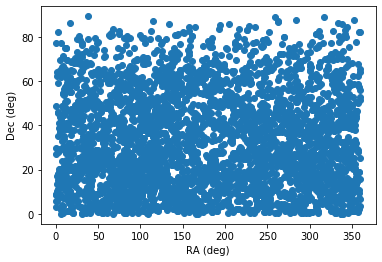

In [174]:
ra_debug = stars_nparr_debug[:,0]
dec_debug = stars_nparr_debug[:,1]
plt.scatter(ra_debug, dec_debug)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show();

In [ ]:
# filter stars_arr for debugging


In [175]:
stars_nparr_debug = np.array(stars_arr_debug)
stars_nparr_debug2 = np.array(stars_arr)[:,0:2]

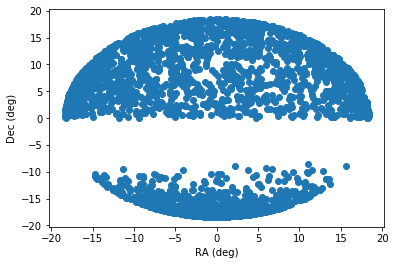

In [176]:
# Z axis flattened

# ra_debug2 = [stars_nparr_debug2[i,0] if stars_nparr_debug2[i,2] > 0 for i in stars_nparr_debug2[:,0]]
# dec_debug2 = [stars_nparr_debug2[i,1] if stars_nparr_debug2[i,2] > 0 for i in stars_nparr_debug2[:,1]]
ra_debug2 = stars_nparr_debug2[:,0]
dec_debug2 = stars_nparr_debug2[:,1]
plt.scatter(ra_debug2, dec_debug2)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show();

In [122]:
ra_max = stars_nparr_debug2[:,0].max()
ra_min = stars_nparr_debug2[:,0].min()
dec_max = stars_nparr_debug2[:,1].max()
dec_min = stars_nparr_debug2[:,1].min()

print(f'RA ranges from {ra_min} to {ra_max},\nDec ranges from {dec_min} to {dec_max}')

RA ranges from -18.3989 to 18.3947,
Dec ranges from -18.4 to 18.4


18.3947

In [117]:
stars_nparr_debug2

array([[-0.5884, 18.3877],
       [-0.5747, 18.3813],
       [-0.8179, 18.368 ],
       ...,
       [11.751 , 12.6983],
       [12.1258, 12.9124],
       [10.0569, 14.483 ]])